In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train = pd.read_csv('image_tagging/train.csv') # set limit, delete "nrows" to undo
train.drop(['Name'],axis=1,inplace=True)
train.drop(train[train["Key"] == "182.429"].index, inplace=True) # invalid row
train.reset_index(drop=True, inplace=True)
train.head()

,Key,Type,normal,fire,water,grass,electric,ice,fighting,poison,ground,flying,psychic,bug,rock,ghost,dragon,dark,steel,fairy
0,110.95,"poison, ground",0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
1,155.408,"fire, fairy",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,360.381,"grass, psychic",0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,6.142e,"fire, flying",0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,289.175,"bug, fairy",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [4]:
train.columns

Index(['Key', 'Type', 'normal', 'fire', 'water', 'grass', 'electric', 'ice',
       'fighting', 'poison', 'ground', 'flying', 'psychic', 'bug', 'rock',
       'ghost', 'dragon', 'dark', 'steel', 'fairy'],
      dtype='object')

In [5]:
TRAINING_DATASET = "/blue/rcstudents/smaley/pokegan/customsprites/blk_bg/input"
# IMAGE_SIZE = (256,256,3)
IMAGE_SIZE = (64,64,3) # try scaling down

train_image = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img(f"{TRAINING_DATASET}/{train.at[i, 'Key']}.png",target_size=IMAGE_SIZE)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 81649/81649 [01:57<00:00, 692.87it/s]


In [6]:
X.shape

(81649, 64, 64, 3)

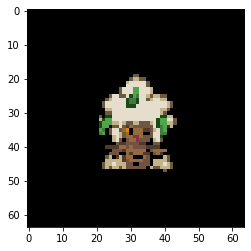

In [7]:
plt.imshow(X[2])

In [8]:
train['Type'][2]

'grass, psychic'

In [9]:
y = np.array(train.drop(['Key', 'Type'],axis=1))
y.shape

(81649, 18)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [13]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Load Pretrained Base Model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_model.trainable = False  # Freeze the base model

# Build the Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reduces feature maps to a single vector
    Dense(256, activation='relu'),  # Custom dense layer
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),  # Another dense layer
    BatchNormalization(),
    Dropout(0.5),
    Dense(18, activation='sigmoid')  # Output layer for multi-label classification
])

2024-12-04 14:16:55.544138: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 14:16:56.256745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78902 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0


16719872/16705208 [==============================] - 0s 0us/step


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 2, 2, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               3

In [15]:
# Compile the Model
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='binary_crossentropy', 
              metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(k=2)])

In [17]:
# Fine-Tuning
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/50


2024-12-04 14:17:47.179382: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2024-12-04 14:17:47.842749: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-04 14:17:47.843868: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-04 14:17:47.843905: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-12-04 14:17:47.844661: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-04 14:17:47.844719: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


  20/2297 [..............................] - ETA: 18s - loss: 0.9861 - accuracy: 0.0547 - top_k_categorical_accuracy: 0.1094

2024-12-04 14:17:48.821647: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2297/2297 [==============================] - 27s 10ms/step - loss: 0.6590 - accuracy: 0.0711 - top_k_categorical_accuracy: 0.1382 - val_loss: 0.3857 - val_accuracy: 0.2158 - val_top_k_categorical_accuracy: 0.3084 - lr: 1.0000e-04
Epoch 2/50
2297/2297 [==============================] - 21s 9ms/step - loss: 0.3869 - accuracy: 0.1310 - top_k_categorical_accuracy: 0.2341 - val_loss: 0.3346 - val_accuracy: 0.2158 - val_top_k_categorical_accuracy: 0.3776 - lr: 1.0000e-04
Epoch 3/50
2297/2297 [==============================] - 22s 9ms/step - loss: 0.3655 - accuracy: 0.1595 - top_k_categorical_accuracy: 0.2858 - val_loss: 0.3345 - val_accuracy: 0.2158 - val_top_k_categorical_accuracy: 0.3776 - lr: 1.0000e-04
Epoch 4/50
2297/2297 [==============================] - 21s 9ms/step - loss: 0.3563 - accuracy: 0.1737 - top_k_categorical_accuracy: 0.3122 - val_loss: 0.3343 - val_accuracy: 0.2158 - val_top_k_categorical_accuracy: 0.3776 - lr: 1.0000e-04
Epoch 5/50
2297/2297 [============================

In [18]:
model.save('64_transfer_finetune_50_epoch.keras')

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [19]:
# Unfreeze some layers of the base model
base_model.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(k=2)])

# Fine-tune the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,  # Fewer epochs for fine-tuning
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/30
2297/2297 [==============================] - 66s 26ms/step - loss: 0.3381 - accuracy: 0.2102 - top_k_categorical_accuracy: 0.3717 - val_loss: 0.3343 - val_accuracy: 0.2158 - val_top_k_categorical_accuracy: 0.3776 - lr: 1.0000e-05
Epoch 2/30
2297/2297 [==============================] - 59s 25ms/step - loss: 0.3367 - accuracy: 0.2112 - top_k_categorical_accuracy: 0.3727 - val_loss: 0.3326 - val_accuracy: 0.2170 - val_top_k_categorical_accuracy: 0.3816 - lr: 1.0000e-05
Epoch 3/30
2297/2297 [==============================] - 58s 25ms/step - loss: 0.3346 - accuracy: 0.2202 - top_k_categorical_accuracy: 0.3809 - val_loss: 0.3327 - val_accuracy: 0.2094 - val_top_k_categorical_accuracy: 0.3805 - lr: 1.0000e-05
Epoch 4/30
2297/2297 [==============================] - 58s 25ms/step - loss: 0.3327 - accuracy: 0.2266 - top_k_categorical_accuracy: 0.3919 - val_loss: 0.3318 - val_accuracy: 0.1988 - val_top_k_categorical_accuracy: 0.3867 - lr: 1.0000e-05
Epoch 5/30
2297/2297 [==============

In [20]:
model.save('64_transfer_full_50_30_epoch.keras')

In [5]:
from keras.models import load_model

model = load_model("64_transfer_full_50_30_epoch.keras")

2024-12-04 15:55:34.195128: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 15:55:34.982108: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78902 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0


In [6]:
import csv

file_path = "image_tagging/all_pokemon_to_type.csv"
pokedex = {}

with open(file_path, mode='r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        key = row['Key']
        value = {col: row[col] for col in row if col != 'Key'}
        pokedex[key] = value

print(pokedex["338.287i"])

{'Type': 'dark, fairy', 'Name': 'Zoroark/Gardevoir', 'Body': '338', 'Head': '287'}


NameError: name 'TRAINING_DATASET' is not defined

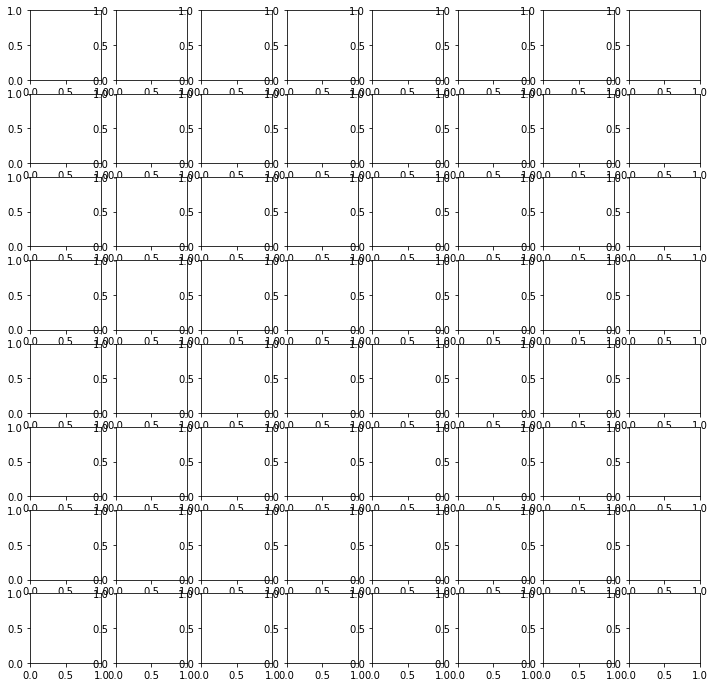

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Constants
GRID_SIZE = 8  # 8x8 grid
OUTPUT_FILE = "predictions_grid_4.png"  # Output file name

# Variables
count = 0
fig, axes = plt.subplots(GRID_SIZE, GRID_SIZE, figsize=(12, 12))
axes = axes.flatten()

# Iterate through the dataset
for idx, file_name in enumerate(os.listdir(TRAINING_DATASET)):
    if count >= GRID_SIZE * GRID_SIZE:  # Limit to 64 images
        break
    
    # Load and preprocess the image
    img_path = os.path.join(TRAINING_DATASET, file_name)
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img) / 255.0  # Normalize
    classes = np.array(train.columns[2:])
    
    # Make predictions
    proba = model.predict(img_array.reshape(1,64,64,3))
    top_2 = np.argsort(proba[0])[:-3:-1]  # Get top 2 predictions
    top_2_predictions = [f"{classes[i]} ({proba[0][i]:.2f})" for i in top_2]
    
    # Get ground truth
    ground_truth = pokedex[file_name[:-4]]["Type"]
    
    # Plot image in grid
    axes[idx].imshow(image.load_img(img_path,target_size=(256,256,3)))
    axes[idx].axis('off')  # Turn off axis
    axes[idx].set_title(f"P: {', '.join(top_2_predictions)}\nA: {ground_truth}", fontsize=6)
    
    count += 1

# Adjust layout and save the grid
plt.tight_layout()
plt.savefig(OUTPUT_FILE, dpi=300)
plt.show()